## Image Classification using Traditional Machine Learning
- Purpose: Use classical ML algorithms (Random Forest, SVM, etc.) for image classification

### Import Libraries and Setup

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.feature import hog
from tensorflow import keras
import seaborn as sns
import warnings
import time
import ssl
import urllib.request
import os

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

# Fix SSL certificate issue
ssl._create_default_https_context = ssl._create_unverified_context
os.environ['PYTHONHTTPSVERIFY'] = '0'

print("All libraries imported successfully!")
print(f"scikit-learn imported successfully")
print(f"scikit-image imported successfully")
print(f"NumPy version: {np.__version__}")

All libraries imported successfully!
scikit-learn imported successfully
scikit-image imported successfully
NumPy version: 2.2.6


### Load and Prepare Dataset

Loading MNIST dataset...
Method 1 failed: URL fetch failure on https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1032)

Trying alternative method...
✓ Download complete!
✓ Dataset loaded successfully from local file

Dataset Information:
Training samples: 10,000
Test samples: 2,000
Image shape: 28 x 28
Number of classes: 10


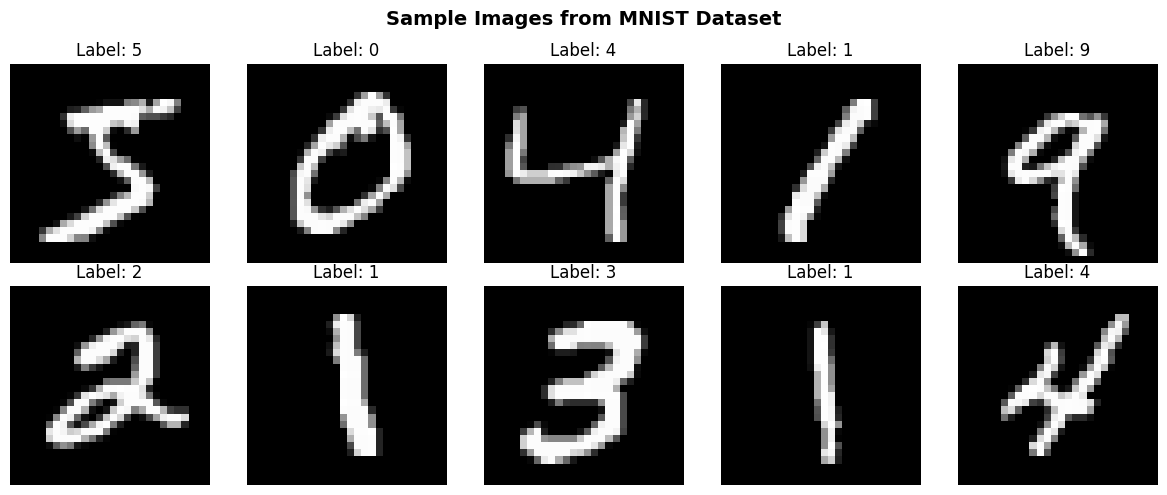

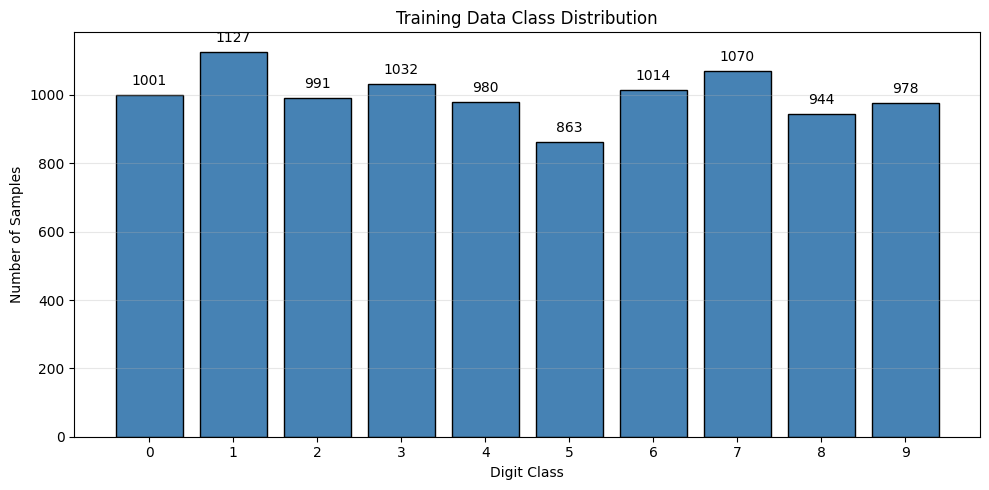


Flattened data shape:
Training: (10000, 784)
Test: (2000, 784)


In [8]:
import numpy as np
import ssl
import urllib.request
import os

# Multiple approaches to fix SSL issue
try:
    ssl._create_default_https_context = ssl._create_unverified_context
    os.environ['PYTHONHTTPSVERIFY'] = '0'
except:
    pass

# Try to load MNIST dataset with multiple fallback methods
print("Loading MNIST dataset...")

# Method 1: Try standard keras load
try:
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    print("✓ Dataset loaded successfully using keras.datasets")
    
except Exception as e:
    print(f"Method 1 failed: {e}")
    print("\nTrying alternative method...")
    
    # Method 2: Manual download
    try:
        cache_dir = os.path.expanduser('~/.keras/datasets')
        os.makedirs(cache_dir, exist_ok=True)
        mnist_path = os.path.join(cache_dir, 'mnist.npz')
        
        if not os.path.exists(mnist_path):
            print("Downloading MNIST dataset manually...")
            url = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz'
            
            # Create opener that ignores SSL
            context = ssl._create_unverified_context()
            opener = urllib.request.build_opener(urllib.request.HTTPSHandler(context=context))
            urllib.request.install_opener(opener)
            
            urllib.request.urlretrieve(url, mnist_path)
            print("✓ Download complete!")
        
        # Load from file
        with np.load(mnist_path, allow_pickle=True) as f:
            X_train, y_train = f['x_train'], f['y_train']
            X_test, y_test = f['x_test'], f['y_test']
        
        print("✓ Dataset loaded successfully from local file")
        
    except Exception as e2:
        print(f"Method 2 failed: {e2}")
        print("\nTrying sklearn method...")
        
        # Method 3: Use sklearn
        try:
            from sklearn.datasets import fetch_openml
            
            print("Loading MNIST from sklearn (this may take a moment)...")
            mnist = fetch_openml('mnist_784', version=1, parser='auto', as_frame=False)
            X_all = mnist.data.reshape(-1, 28, 28).astype('uint8')
            y_all = mnist.target.astype('uint8')
            
            # Split into train and test
            X_train = X_all[:60000]
            y_train = y_all[:60000]
            X_test = X_all[60000:]
            y_test = y_all[60000:]
            
            print("✓ Dataset loaded successfully from sklearn")
            
        except Exception as e3:
            print(f"Method 3 failed: {e3}")
            print("\n❌ All methods failed. Please download the dataset manually.")
            print("\nManual download instructions:")
            print("1. Download from: https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz")
            print("2. Save to: ~/.keras/datasets/mnist.npz")
            print("3. Re-run this cell")
            raise Exception("Could not load MNIST dataset")

# Use a subset for faster training
n_train_samples = 10000
n_test_samples = 2000

X_train_ml = X_train[:n_train_samples]
y_train_ml = y_train[:n_train_samples]
X_test_ml = X_test[:n_test_samples]
y_test_ml = y_test[:n_test_samples]

print(f"\nDataset Information:")
print(f"Training samples: {len(X_train_ml):,}")
print(f"Test samples: {len(X_test_ml):,}")
print(f"Image shape: {X_train_ml.shape[1]} x {X_train_ml.shape[2]}")
print(f"Number of classes: {len(np.unique(y_train_ml))}")

# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train_ml[i], cmap='gray')
    ax.set_title(f'Label: {y_train_ml[i]}')
    ax.axis('off')
plt.suptitle('Sample Images from MNIST Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Show class distribution
unique, counts = np.unique(y_train_ml, return_counts=True)
plt.figure(figsize=(10, 5))
plt.bar(unique, counts, color='steelblue', edgecolor='black')
plt.xlabel('Digit Class')
plt.ylabel('Number of Samples')
plt.title('Training Data Class Distribution')
plt.xticks(unique)
plt.grid(axis='y', alpha=0.3)
for i, (digit, count) in enumerate(zip(unique, counts)):
    plt.text(digit, count + 20, str(count), ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Flatten images for traditional ML
X_train_flat = X_train_ml.reshape(n_train_samples, -1).astype('float32') / 255.0
X_test_flat = X_test_ml.reshape(n_test_samples, -1).astype('float32') / 255.0

print(f"\nFlattened data shape:")
print(f"Training: {X_train_flat.shape}")
print(f"Test: {X_test_flat.shape}")

### Extract HOG Features

Extracting HOG features from training set...
Extracting HOG features from test set...

HOG Feature Extraction Complete!
Training set extraction time: 0.46 seconds
Test set extraction time: 0.09 seconds
Original feature dimension: 784
HOG feature dimension: 144
Dimensionality reduction: 81.6%


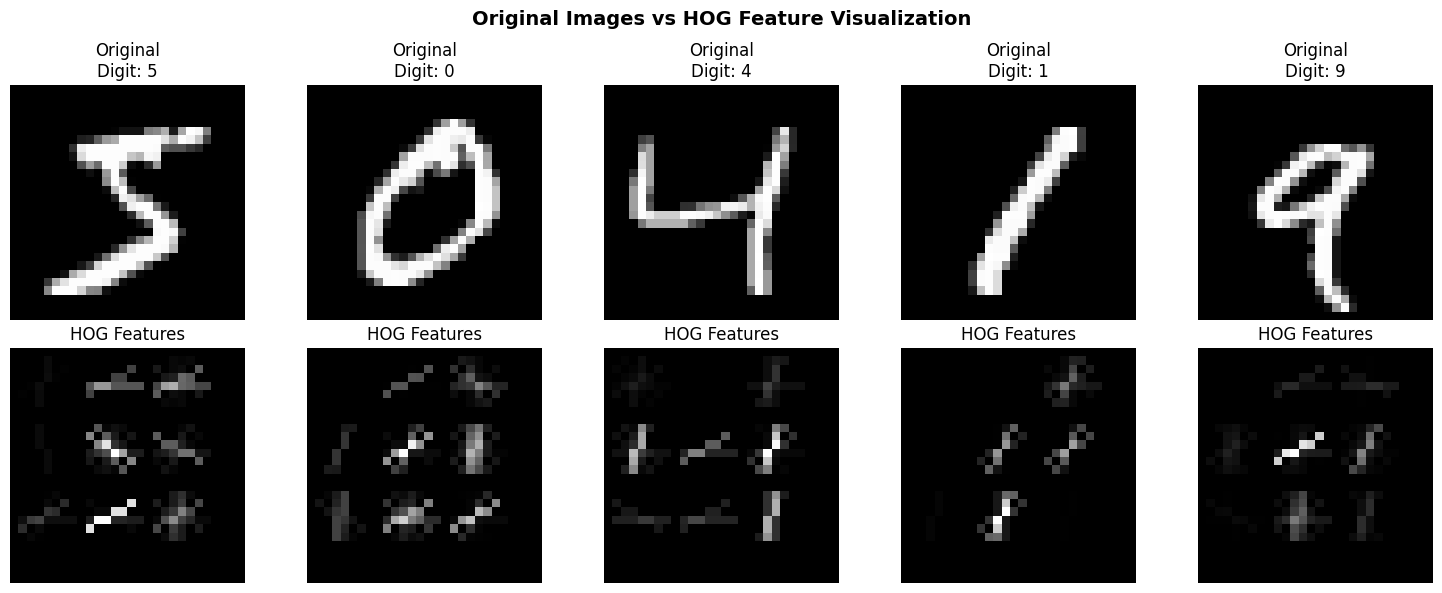

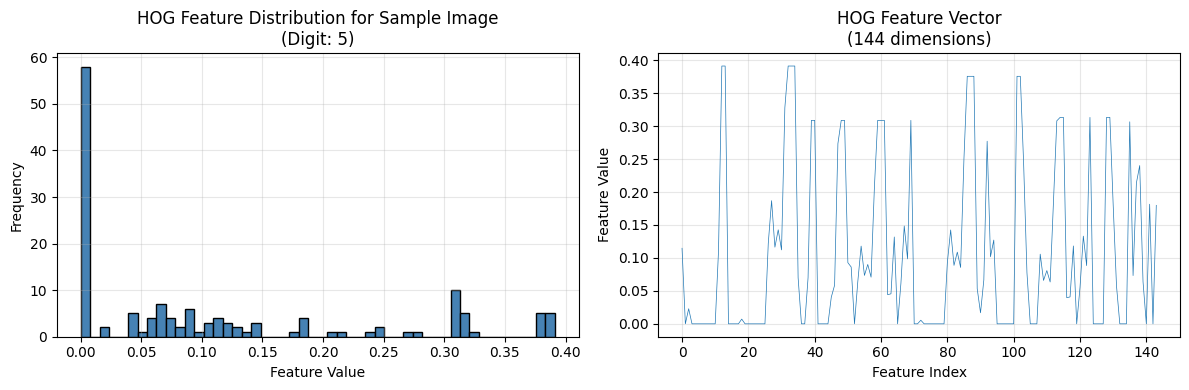

In [9]:
# Function to extract HOG features
def extract_hog_features(images, image_shape=(28, 28)):
    """
    Extract HOG (Histogram of Oriented Gradients) features from images
    """
    hog_features = []
    for img in images:
        img_reshaped = img.reshape(image_shape)
        features = hog(img_reshaped, 
                      orientations=9,
                      pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2),
                      visualize=False,
                      feature_vector=True)
        hog_features.append(features)
    return np.array(hog_features)

# Extract HOG features
print("Extracting HOG features from training set...")
start_time = time.time()
X_train_hog = extract_hog_features(X_train_ml)
train_time = time.time() - start_time

print(f"Extracting HOG features from test set...")
start_time = time.time()
X_test_hog = extract_hog_features(X_test_ml)
test_time = time.time() - start_time

print(f"\nHOG Feature Extraction Complete!")
print(f"Training set extraction time: {train_time:.2f} seconds")
print(f"Test set extraction time: {test_time:.2f} seconds")
print(f"Original feature dimension: {X_train_flat.shape[1]}")
print(f"HOG feature dimension: {X_train_hog.shape[1]}")
print(f"Dimensionality reduction: {(1 - X_train_hog.shape[1]/X_train_flat.shape[1])*100:.1f}%")

# Visualize HOG for sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):
    # Original image
    axes[0, i].imshow(X_train_ml[i], cmap='gray')
    axes[0, i].set_title(f'Original\nDigit: {y_train_ml[i]}')
    axes[0, i].axis('off')
    
    # HOG visualization
    hog_features, hog_image = hog(X_train_ml[i],
                                   orientations=9,
                                   pixels_per_cell=(8, 8),
                                   cells_per_block=(2, 2),
                                   visualize=True)
    axes[1, i].imshow(hog_image, cmap='gray')
    axes[1, i].set_title('HOG Features')
    axes[1, i].axis('off')

plt.suptitle('Original Images vs HOG Feature Visualization', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Visualize HOG feature distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(X_train_hog[0], bins=50, color='steelblue', edgecolor='black')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.title(f'HOG Feature Distribution for Sample Image\n(Digit: {y_train_ml[0]})')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(X_train_hog[0], linewidth=0.5)
plt.xlabel('Feature Index')
plt.ylabel('Feature Value')
plt.title(f'HOG Feature Vector\n({X_train_hog.shape[1]} dimensions)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Apply PCA for Dimensionality Reduction

Applying PCA to reduce dimensions to 50 components...

PCA Results:
Original HOG features: 144 dimensions
PCA reduced features: 50 dimensions
Explained variance ratio: 0.9480 (94.80%)
Dimensionality reduction: 65.3%


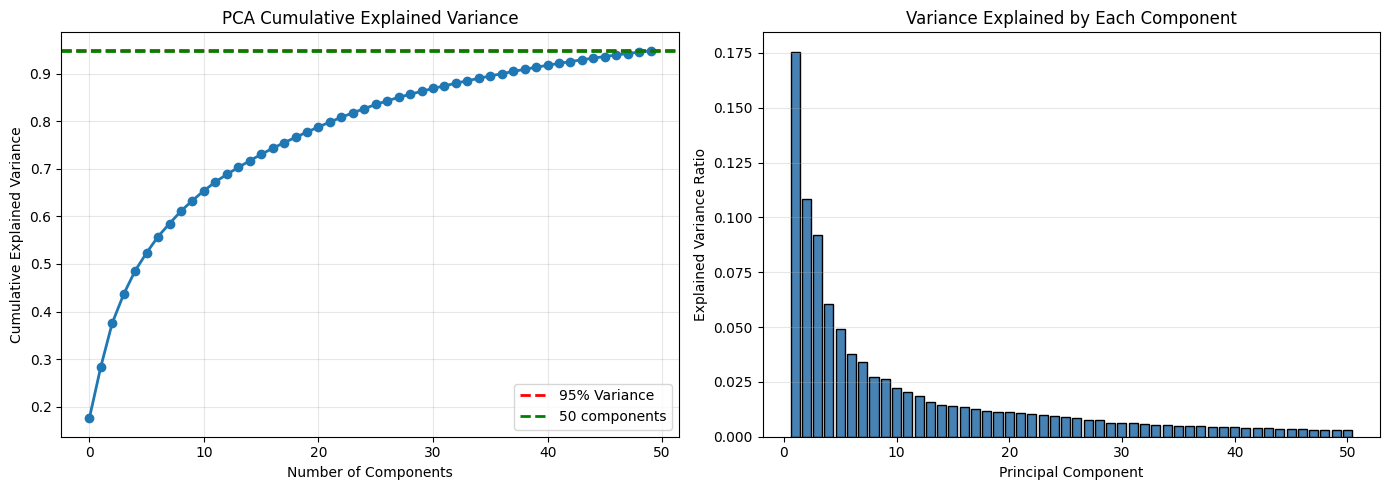

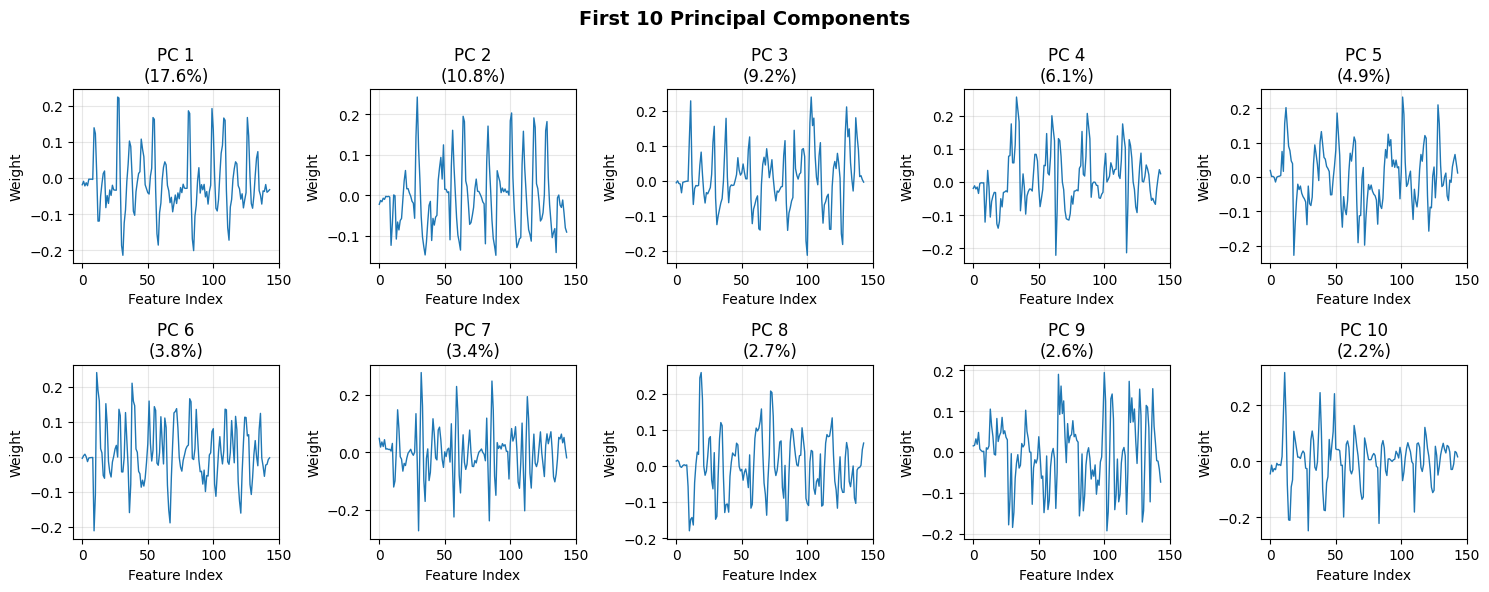

In [10]:
# Apply PCA to reduce dimensions
n_components = 50
print(f"Applying PCA to reduce dimensions to {n_components} components...")

pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_hog)
X_test_pca = pca.transform(X_test_hog)

print(f"\nPCA Results:")
print(f"Original HOG features: {X_train_hog.shape[1]} dimensions")
print(f"PCA reduced features: {X_train_pca.shape[1]} dimensions")
print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.4f} ({np.sum(pca.explained_variance_ratio_)*100:.2f}%)")
print(f"Dimensionality reduction: {(1 - n_components/X_train_hog.shape[1])*100:.1f}%")

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cumulative explained variance
axes[0].plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2, marker='o')
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Cumulative Explained Variance')
axes[0].set_title('PCA Cumulative Explained Variance')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0.95, color='r', linestyle='--', label='95% Variance', linewidth=2)
axes[0].axhline(y=np.sum(pca.explained_variance_ratio_), color='g', 
                linestyle='--', label=f'{n_components} components', linewidth=2)
axes[0].legend()

# Individual explained variance
axes[1].bar(range(1, n_components+1), pca.explained_variance_ratio_, 
            color='steelblue', edgecolor='black')
axes[1].set_xlabel('Principal Component')
axes[1].set_ylabel('Explained Variance Ratio')
axes[1].set_title('Variance Explained by Each Component')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize first few principal components
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    if i < 10:
        # Reshape component to visualize (approximate visualization)
        component = pca.components_[i]
        ax.plot(component, linewidth=1)
        ax.set_title(f'PC {i+1}\n({pca.explained_variance_ratio_[i]*100:.1f}%)')
        ax.set_xlabel('Feature Index')
        ax.set_ylabel('Weight')
        ax.grid(True, alpha=0.3)

plt.suptitle('First 10 Principal Components', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Train Random Forest Classifier

Training Random Forest Classifier...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.3s



Training completed in 0.77 seconds
Making predictions...

Random Forest Results:
Training time: 0.77 seconds
Prediction time: 0.01 seconds
Accuracy: 87.75%
Correct predictions: 1755/2000


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


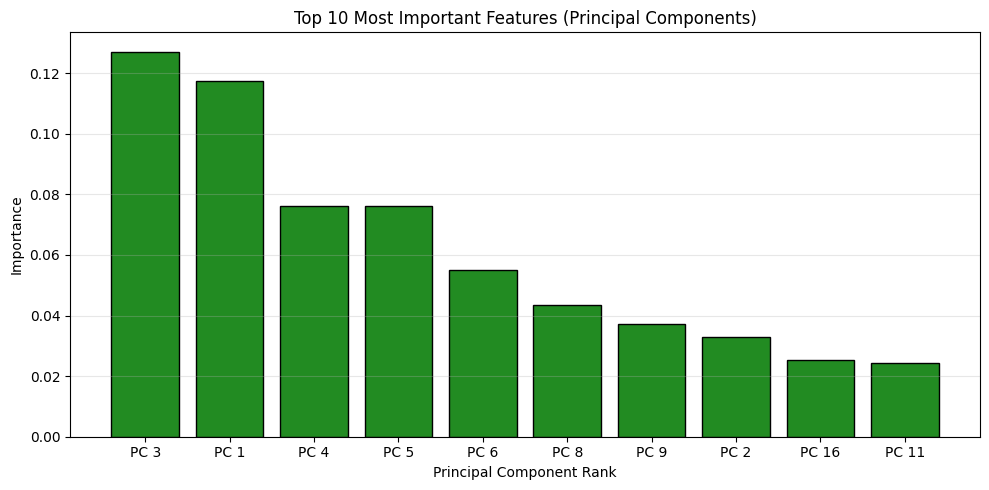

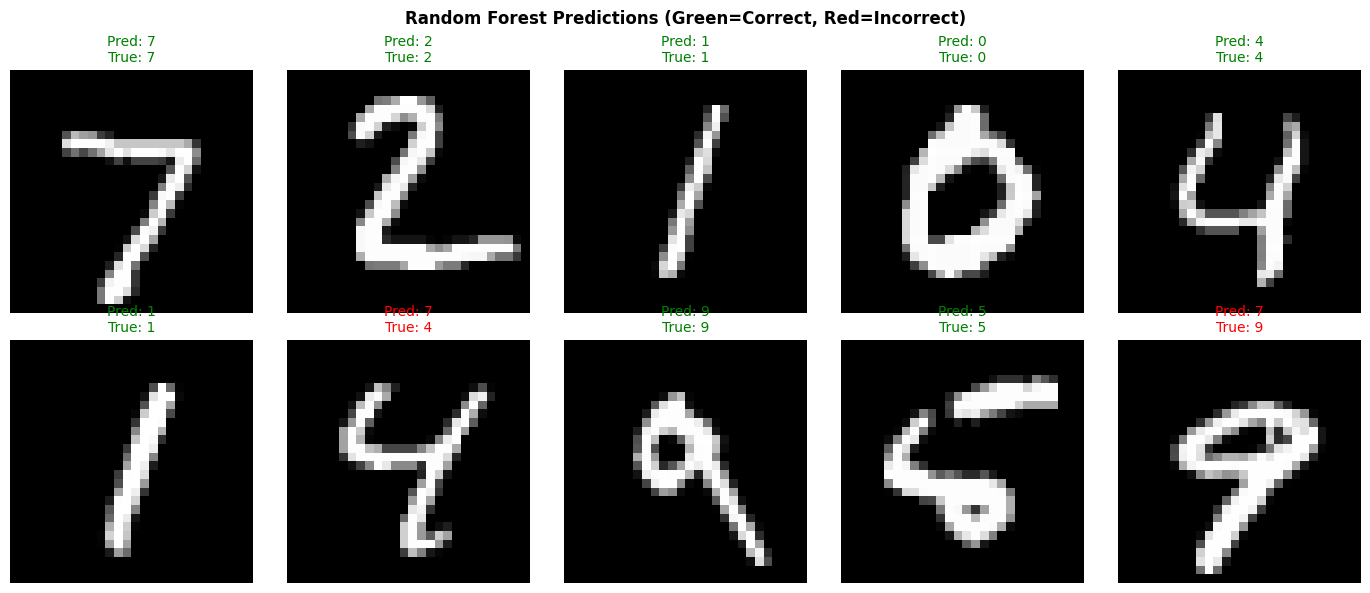

In [11]:
# Train Random Forest
print("="*70)
print("Training Random Forest Classifier...")
print("="*70)

rf_classifier = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1,
    max_depth=20,
    min_samples_split=5,
    verbose=1
)

start_time = time.time()
rf_classifier.fit(X_train_pca, y_train_ml)
rf_train_time = time.time() - start_time

print(f"\nTraining completed in {rf_train_time:.2f} seconds")

# Make predictions
print("Making predictions...")
start_time = time.time()
y_pred_rf = rf_classifier.predict(X_test_pca)
rf_pred_time = time.time() - start_time

# Calculate accuracy
rf_accuracy = accuracy_score(y_test_ml, y_pred_rf)

print(f"\n{'='*70}")
print(f"Random Forest Results:")
print(f"{'='*70}")
print(f"Training time: {rf_train_time:.2f} seconds")
print(f"Prediction time: {rf_pred_time:.2f} seconds")
print(f"Accuracy: {rf_accuracy*100:.2f}%")
print(f"Correct predictions: {np.sum(y_pred_rf == y_test_ml)}/{len(y_test_ml)}")
print(f"{'='*70}")

# Feature importance
feature_importance = rf_classifier.feature_importances_
top_features = np.argsort(feature_importance)[-10:][::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(10), feature_importance[top_features], color='forestgreen', edgecolor='black')
plt.xlabel('Principal Component Rank')
plt.ylabel('Importance')
plt.title('Top 10 Most Important Features (Principal Components)')
plt.xticks(range(10), [f'PC {i+1}' for i in top_features])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Display sample predictions
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test_ml[i], cmap='gray')
    pred_label = y_pred_rf[i]
    true_label = y_test_ml[i]
    
    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f'Pred: {pred_label}\nTrue: {true_label}', color=color, fontsize=10)
    ax.axis('off')

plt.suptitle('Random Forest Predictions (Green=Correct, Red=Incorrect)', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

### Train SVM Classifier

Training SVM Classifier...
[LibSVM]*
optimization finished, #iter = 403
obj = -52.411364, rho = 0.417361
nSV = 130, nBSV = 0
*
optimization finished, #iter = 589
obj = -62.292880, rho = 0.453400
nSV = 191, nBSV = 0
*
optimization finished, #iter = 586
obj = -81.474469, rho = -0.078894
nSV = 179, nBSV = 0
*
optimization finished, #iter = 490
obj = -62.468314, rho = 0.308605
nSV = 178, nBSV = 0
*
optimization finished, #iter = 428
obj = -55.937034, rho = 0.285089
nSV = 152, nBSV = 0
*
optimization finished, #iter = 583
obj = -99.665272, rho = 0.069435
nSV = 169, nBSV = 0
*
optimization finished, #iter = 399
obj = -45.641653, rho = 0.355653
nSV = 154, nBSV = 0
*
optimization finished, #iter = 609
obj = -105.889439, rho = -0.556050
nSV = 166, nBSV = 0
*
optimization finished, #iter = 675
obj = -94.611442, rho = -0.160629
nSV = 181, nBSV = 0
*
optimization finished, #iter = 570
obj = -89.178865, rho = -0.074900
nSV = 198, nBSV = 0
*
optimization finished, #iter = 345
obj = -34.078185, rho =

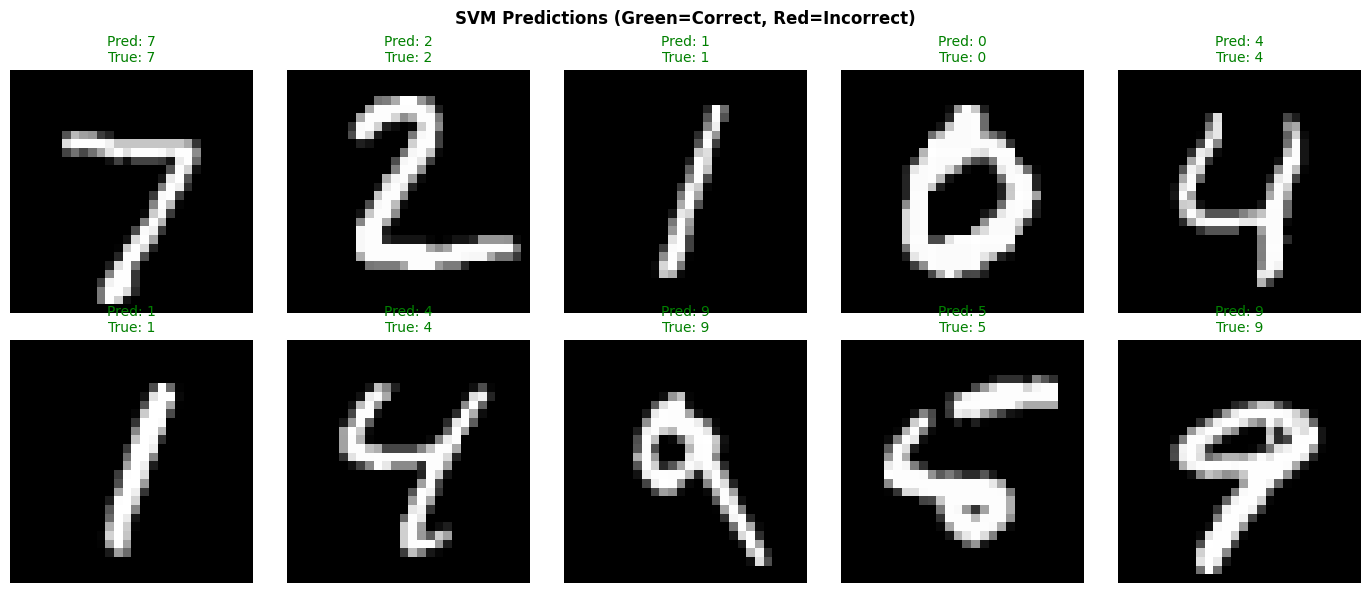

In [12]:
# Train SVM
print("="*70)
print("Training SVM Classifier...")
print("="*70)

svm_classifier = SVC(
    kernel='rbf', 
    C=10, 
    gamma='scale', 
    random_state=42,
    verbose=True
)

start_time = time.time()
svm_classifier.fit(X_train_pca, y_train_ml)
svm_train_time = time.time() - start_time

print(f"\nTraining completed in {svm_train_time:.2f} seconds")

# Make predictions
print("Making predictions...")
start_time = time.time()
y_pred_svm = svm_classifier.predict(X_test_pca)
svm_pred_time = time.time() - start_time

# Calculate accuracy
svm_accuracy = accuracy_score(y_test_ml, y_pred_svm)

print(f"\n{'='*70}")
print(f"SVM Results:")
print(f"{'='*70}")
print(f"Training time: {svm_train_time:.2f} seconds")
print(f"Prediction time: {svm_pred_time:.2f} seconds")
print(f"Accuracy: {svm_accuracy*100:.2f}%")
print(f"Correct predictions: {np.sum(y_pred_svm == y_test_ml)}/{len(y_test_ml)}")
print(f"Number of support vectors: {len(svm_classifier.support_)}")
print(f"{'='*70}")

# Display sample predictions
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test_ml[i], cmap='gray')
    pred_label = y_pred_svm[i]
    true_label = y_test_ml[i]
    
    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f'Pred: {pred_label}\nTrue: {true_label}', color=color, fontsize=10)
    ax.axis('off')

plt.suptitle('SVM Predictions (Green=Correct, Red=Incorrect)', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

### Train K-Nearest Neighbors Classifier

Training K-Nearest Neighbors Classifier...

Training completed in 0.00 seconds
Making predictions...

KNN Results:
Training time: 0.00 seconds
Prediction time: 0.10 seconds
Accuracy: 90.15%
Correct predictions: 1803/2000


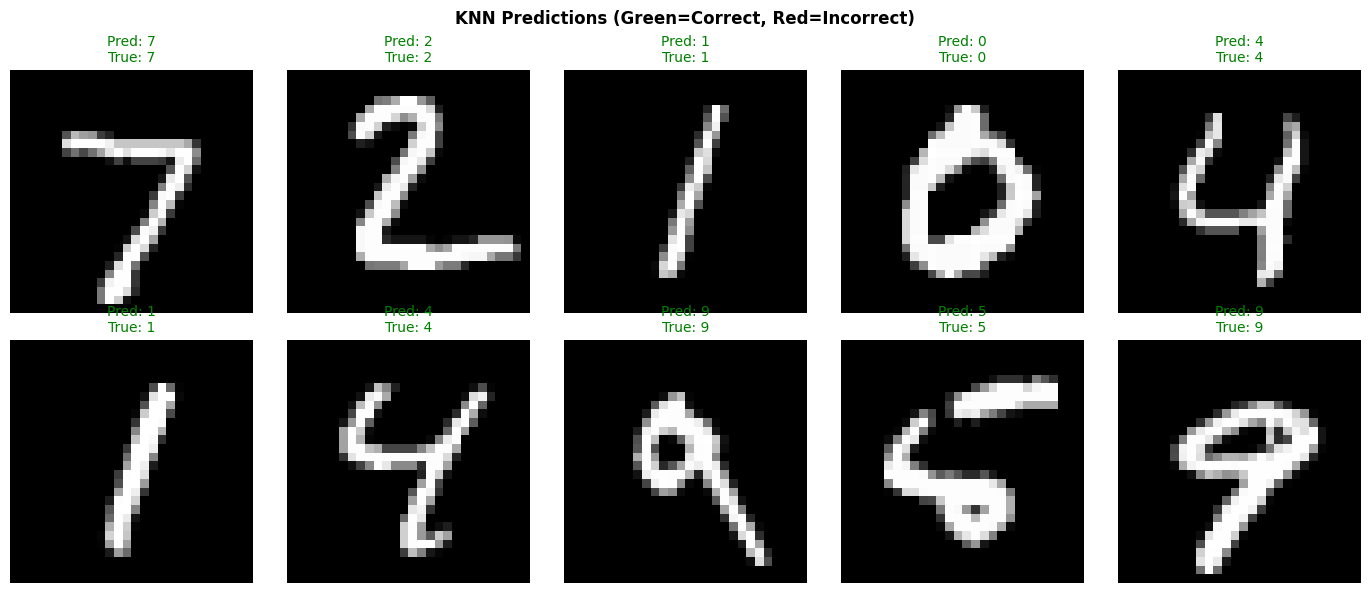

In [13]:
# Train KNN
print("="*70)
print("Training K-Nearest Neighbors Classifier...")
print("="*70)

knn_classifier = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    n_jobs=-1
)

start_time = time.time()
knn_classifier.fit(X_train_pca, y_train_ml)
knn_train_time = time.time() - start_time

print(f"\nTraining completed in {knn_train_time:.2f} seconds")

# Make predictions
print("Making predictions...")
start_time = time.time()
y_pred_knn = knn_classifier.predict(X_test_pca)
knn_pred_time = time.time() - start_time

# Calculate accuracy
knn_accuracy = accuracy_score(y_test_ml, y_pred_knn)

print(f"\n{'='*70}")
print(f"KNN Results:")
print(f"{'='*70}")
print(f"Training time: {knn_train_time:.2f} seconds")
print(f"Prediction time: {knn_pred_time:.2f} seconds")
print(f"Accuracy: {knn_accuracy*100:.2f}%")
print(f"Correct predictions: {np.sum(y_pred_knn == y_test_ml)}/{len(y_test_ml)}")
print(f"{'='*70}")

# Display sample predictions
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test_ml[i], cmap='gray')
    pred_label = y_pred_knn[i]
    true_label = y_test_ml[i]
    
    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f'Pred: {pred_label}\nTrue: {true_label}', color=color, fontsize=10)
    ax.axis('off')

plt.suptitle('KNN Predictions (Green=Correct, Red=Incorrect)', 
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

### Classification Reports and Confusion Matrices


CLASSIFICATION REPORTS

1. Random Forest Classification Report:
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       175
           1       0.96      0.98      0.97       234
           2       0.89      0.90      0.90       219
           3       0.85      0.77      0.81       207
           4       0.92      0.85      0.88       217
           5       0.92      0.86      0.89       179
           6       0.90      0.91      0.90       178
           7       0.84      0.87      0.86       205
           8       0.77      0.79      0.78       192
           9       0.81      0.88      0.85       194

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000


2. SVM Classification Report:
----------------------------------------------------------------------
   

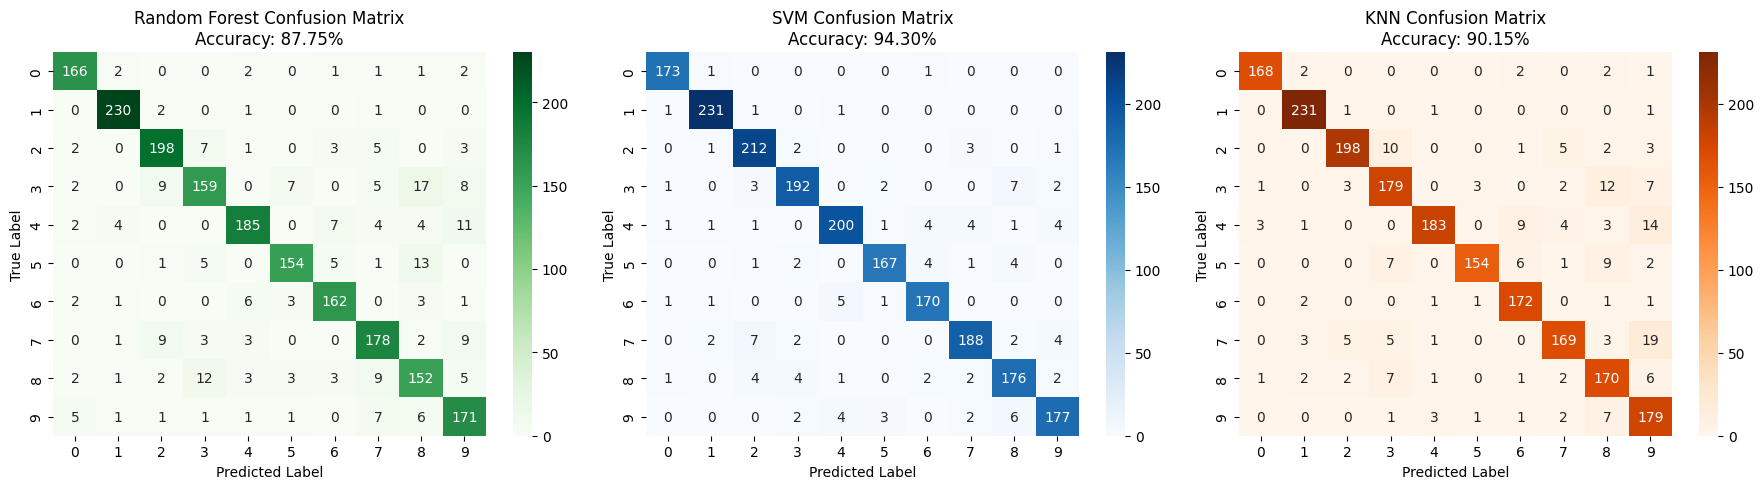

In [14]:
# Classification reports for all models
print("\n" + "="*70)
print("CLASSIFICATION REPORTS")
print("="*70)

print("\n1. Random Forest Classification Report:")
print("-"*70)
print(classification_report(y_test_ml, y_pred_rf, 
                           target_names=[str(i) for i in range(10)]))

print("\n2. SVM Classification Report:")
print("-"*70)
print(classification_report(y_test_ml, y_pred_svm, 
                           target_names=[str(i) for i in range(10)]))

print("\n3. KNN Classification Report:")
print("-"*70)
print(classification_report(y_test_ml, y_pred_knn, 
                           target_names=[str(i) for i in range(10)]))

# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Random Forest confusion matrix
cm_rf = confusion_matrix(y_test_ml, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=True, 
            xticklabels=range(10), yticklabels=range(10), ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title(f'Random Forest Confusion Matrix\nAccuracy: {rf_accuracy*100:.2f}%')

# SVM confusion matrix
cm_svm = confusion_matrix(y_test_ml, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=range(10), yticklabels=range(10), ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title(f'SVM Confusion Matrix\nAccuracy: {svm_accuracy*100:.2f}%')

# KNN confusion matrix
cm_knn = confusion_matrix(y_test_ml, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Oranges', cbar=True, 
            xticklabels=range(10), yticklabels=range(10), ax=axes[2])
axes[2].set_xlabel('Predicted Label')
axes[2].set_ylabel('True Label')
axes[2].set_title(f'KNN Confusion Matrix\nAccuracy: {knn_accuracy*100:.2f}%')

plt.tight_layout()
plt.show()

### Compare All Traditional ML Models

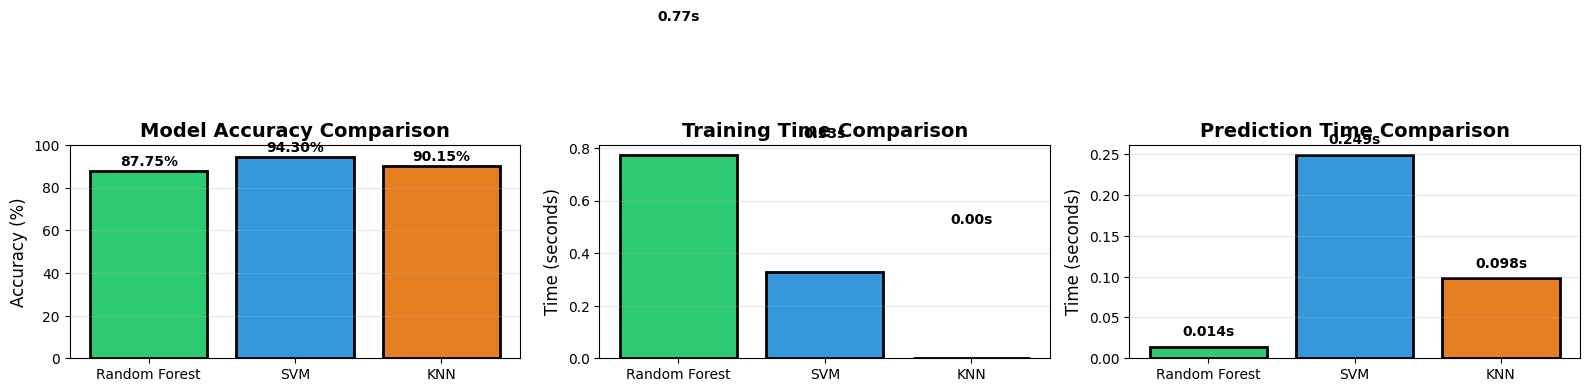

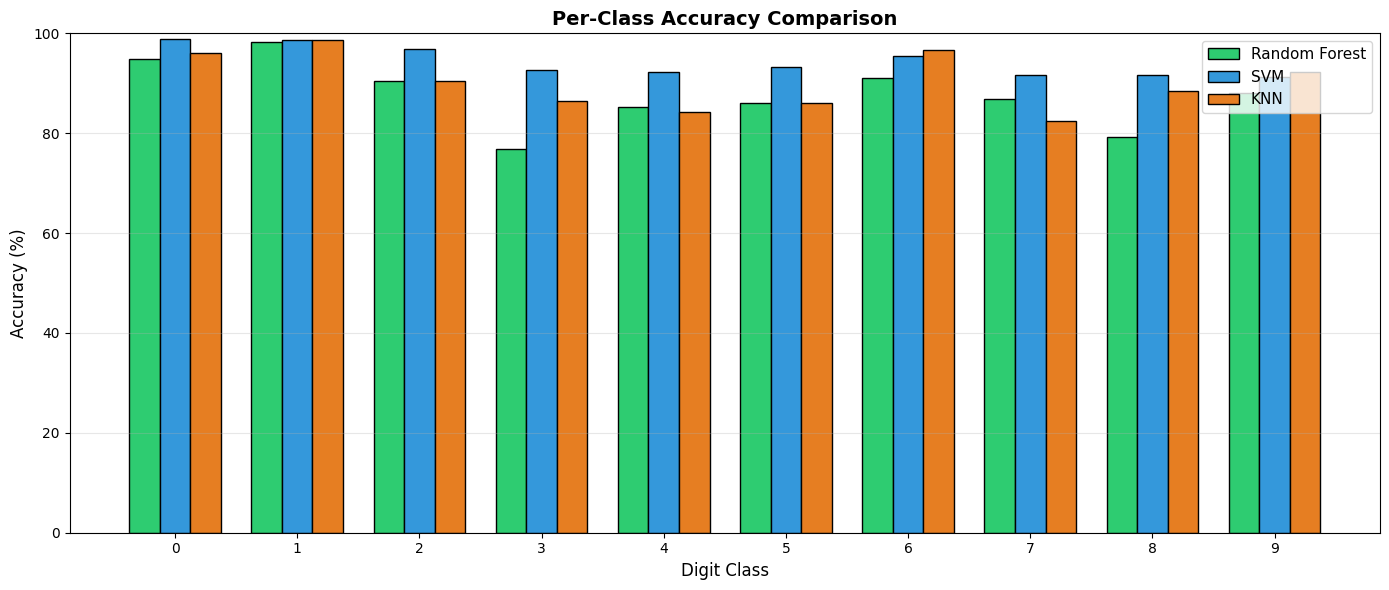

In [15]:
# Create comparison visualization
models = ['Random Forest', 'SVM', 'KNN']
accuracies = [rf_accuracy*100, svm_accuracy*100, knn_accuracy*100]
train_times = [rf_train_time, svm_train_time, knn_train_time]
pred_times = [rf_pred_time, svm_pred_time, knn_pred_time]

# Accuracy comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Accuracy bar plot
bars = axes[0].bar(models, accuracies, color=['#2ecc71', '#3498db', '#e67e22'], 
                   edgecolor='black', linewidth=2)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 100])
axes[0].grid(axis='y', alpha=0.3)
for bar, acc in zip(bars, accuracies):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold')

# Training time comparison
bars = axes[1].bar(models, train_times, color=['#2ecc71', '#3498db', '#e67e22'], 
                   edgecolor='black', linewidth=2)
axes[1].set_ylabel('Time (seconds)', fontsize=12)
axes[1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for bar, time_val in zip(bars, train_times):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{time_val:.2f}s', ha='center', va='bottom', fontweight='bold')

# Prediction time comparison
bars = axes[2].bar(models, pred_times, color=['#2ecc71', '#3498db', '#e67e22'], 
                   edgecolor='black', linewidth=2)
axes[2].set_ylabel('Time (seconds)', fontsize=12)
axes[2].set_title('Prediction Time Comparison', fontsize=14, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)
for bar, time_val in zip(bars, pred_times):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{time_val:.3f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Per-class accuracy comparison
per_class_acc_rf = cm_rf.diagonal() / cm_rf.sum(axis=1)
per_class_acc_svm = cm_svm.diagonal() / cm_svm.sum(axis=1)
per_class_acc_knn = cm_knn.diagonal() / cm_knn.sum(axis=1)

x = np.arange(10)
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width, per_class_acc_rf * 100, width, label='Random Forest', 
               color='#2ecc71', edgecolor='black')
bars2 = ax.bar(x, per_class_acc_svm * 100, width, label='SVM', 
               color='#3498db', edgecolor='black')
bars3 = ax.bar(x + width, per_class_acc_knn * 100, width, label='KNN', 
               color='#e67e22', edgecolor='black')

ax.set_xlabel('Digit Class', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Per-Class Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(range(10))
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 100])

plt.tight_layout()
plt.show()

### Model Comparison with Predictions

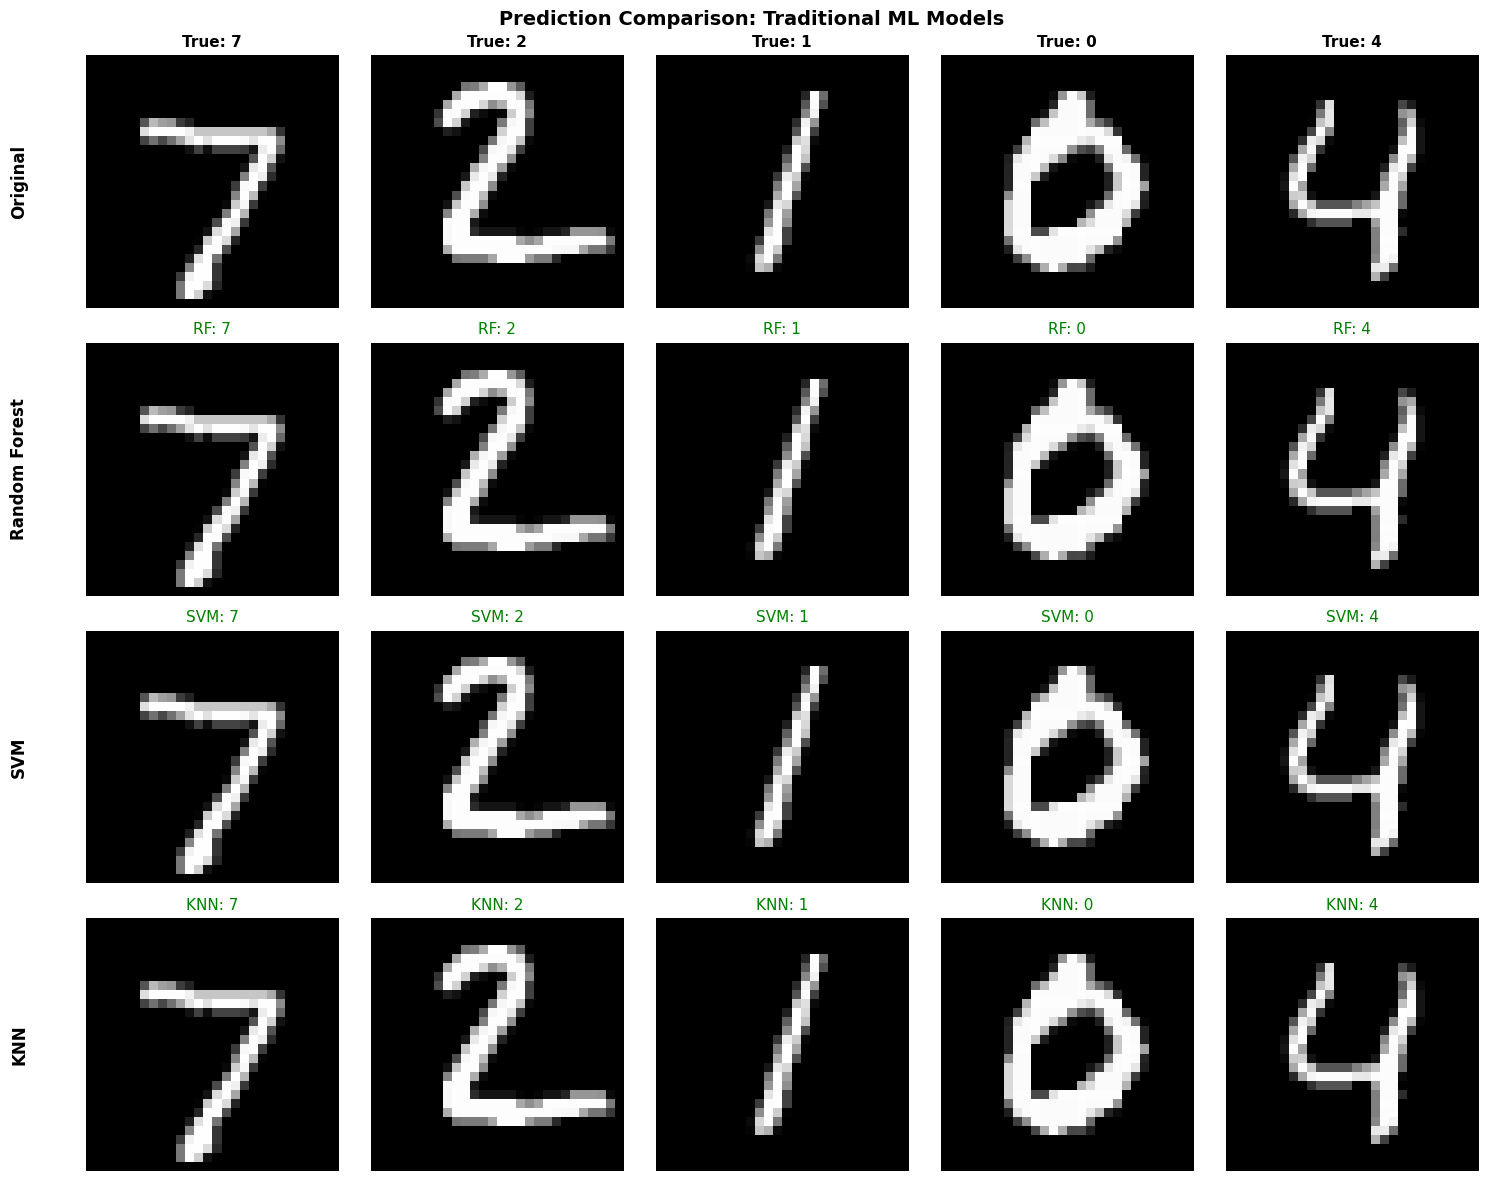


Number of cases where models disagree: 278
Percentage of disagreements: 13.90%


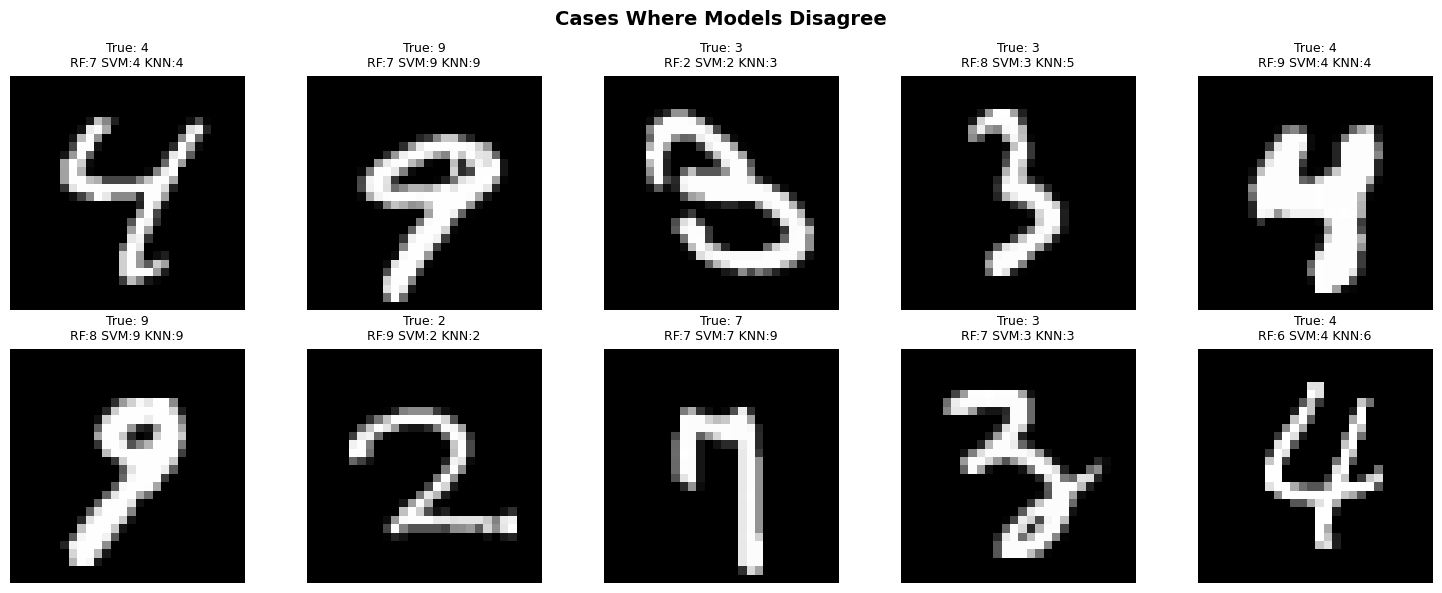

In [16]:
# Compare predictions from all three models on same images
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for i in range(5):
    # Original image
    axes[0, i].imshow(X_test_ml[i], cmap='gray')
    axes[0, i].set_title(f'True: {y_test_ml[i]}', fontsize=11, fontweight='bold')
    axes[0, i].axis('off')
    
    # Random Forest prediction
    axes[1, i].imshow(X_test_ml[i], cmap='gray')
    rf_pred = y_pred_rf[i]
    color = 'green' if rf_pred == y_test_ml[i] else 'red'
    axes[1, i].set_title(f'RF: {rf_pred}', color=color, fontsize=11)
    axes[1, i].axis('off')
    
    # SVM prediction
    axes[2, i].imshow(X_test_ml[i], cmap='gray')
    svm_pred = y_pred_svm[i]
    color = 'green' if svm_pred == y_test_ml[i] else 'red'
    axes[2, i].set_title(f'SVM: {svm_pred}', color=color, fontsize=11)
    axes[2, i].axis('off')
    
    # KNN prediction
    axes[3, i].imshow(X_test_ml[i], cmap='gray')
    knn_pred = y_pred_knn[i]
    color = 'green' if knn_pred == y_test_ml[i] else 'red'
    axes[3, i].set_title(f'KNN: {knn_pred}', color=color, fontsize=11)
    axes[3, i].axis('off')

# Add row labels
axes[0, 0].text(-0.3, 0.5, 'Original', transform=axes[0, 0].transAxes,
                fontsize=12, va='center', rotation=90, fontweight='bold')
axes[1, 0].text(-0.3, 0.5, 'Random Forest', transform=axes[1, 0].transAxes,
                fontsize=12, va='center', rotation=90, fontweight='bold')
axes[2, 0].text(-0.3, 0.5, 'SVM', transform=axes[2, 0].transAxes,
                fontsize=12, va='center', rotation=90, fontweight='bold')
axes[3, 0].text(-0.3, 0.5, 'KNN', transform=axes[3, 0].transAxes,
                fontsize=12, va='center', rotation=90, fontweight='bold')

plt.suptitle('Prediction Comparison: Traditional ML Models', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Find cases where models disagree
disagreements = []
for i in range(len(y_test_ml)):
    preds = [y_pred_rf[i], y_pred_svm[i], y_pred_knn[i]]
    if len(set(preds)) > 1:  # Models disagree
        disagreements.append(i)

print(f"\nNumber of cases where models disagree: {len(disagreements)}")
print(f"Percentage of disagreements: {len(disagreements)/len(y_test_ml)*100:.2f}%")

if len(disagreements) > 0:
    # Show some disagreement cases
    num_show = min(10, len(disagreements))
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    
    for i, ax in enumerate(axes.flat):
        if i < num_show:
            idx = disagreements[i]
            ax.imshow(X_test_ml[idx], cmap='gray')
            ax.set_title(f'True: {y_test_ml[idx]}\nRF:{y_pred_rf[idx]} SVM:{y_pred_svm[idx]} KNN:{y_pred_knn[idx]}',
                        fontsize=9)
        ax.axis('off')
    
    plt.suptitle('Cases Where Models Disagree', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()